# WEST ICRH Antenna Coupling to Water Load
In this notebook, the WEST ICRH antenna is tested against a water load, as performed during the antennas commissioning

<img src="West_Antenna_water_load.png"/>

The distance between the antenna front face and the water tank can be varied. This distance is identified as $D_{aq}$ in the following.

The front-face S-parameter have been calculated in ANYSS HFSS with the antenna front-face facing a salty water load tank of same dimension. The goal is to reproduce and compare the performed measurements. 

In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
from tqdm.notebook import tqdm

import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna
from west_ic_antenna.topica import TopicaResult

In [4]:
# our frequency band of interest, centred around 55 MHz
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')

In [5]:
# HFSS simulations of the front face facing the water tank
s_dir = '../west_ic_antenna/data/Sparameters/front_faces/aquarium/'
# the distance between the antenna front face and the water tank (Daq)
# goes from 0 to 10 cm 
s_files = [f'WEST_ICRH_front_face_with_aquarium_Daq{idx:02}cm.s4p' for idx in range(0,11)]
# insert free-air radiating case 
s_files.insert(0, 'WEST_ICRH_front_face_with_aquarium_without_aquarium.s4p')

## Load Resilience Demonstration
In this example, the antenna is matched for the low and the high coupling case (ie. far from the water load, and close as possible to the water load). Then, the distance to the water load is varied, a situation which demonstrate the load tolerance of the antenna. 

In [6]:
# the water tank is removed from the antenna front face: radiating in vacuum
ant_vac_coupling = WestIcrhAntenna(frequency=freq, antenna_s4p_file=s_dir+s_files[0])

# low coupling case: the water tank is far from the antenna 
ant_low_coupling = WestIcrhAntenna(frequency=freq, antenna_s4p_file=s_dir+s_files[-1])

# intermediate case
ant_med_coupling = WestIcrhAntenna(frequency=freq, antenna_s4p_file=s_dir+s_files[5])

# high coupling case: the water tank is as close as possible of the antenna
ant_high_coupling = WestIcrhAntenna(frequency=freq, antenna_s4p_file=s_dir+s_files[1])

For both cases, we match the left side leaving the other side unmatched (could be the opposite). Capacitance values are rounded to 0.01 pF to match the precision which is feasible in reality. 

In [8]:
f_match = 55e6

C_match_vac = ant_vac_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_vac_coupling.Cs = C_match_vac

C_match_low = ant_low_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_low_coupling.Cs = C_match_low

C_match_med = ant_med_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_med_coupling.Cs = C_match_med

C_match_high = ant_high_coupling.match_one_side(f_match=f_match, side='left', decimals=2)
ant_high_coupling.Cs = C_match_high

Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.53092784 48.28996205]
Rounded result: [50.53, 48.29, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [50.92740496 47.95805066]
Rounded result: [50.93, 47.96, 150.0, 150.0]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [150. 150.]
True solution #1: [51.50970471 47.54279693]
Rounded result: [51.51, 47.54, 150.0, 150.0]
True solution #1: [52.52719861 46.8057412 ]
Rounded result: [52.53, 46.81, 150.0, 150.0]


Let's compare the S11 in both case:

<IPython.core.display.Javascript object>


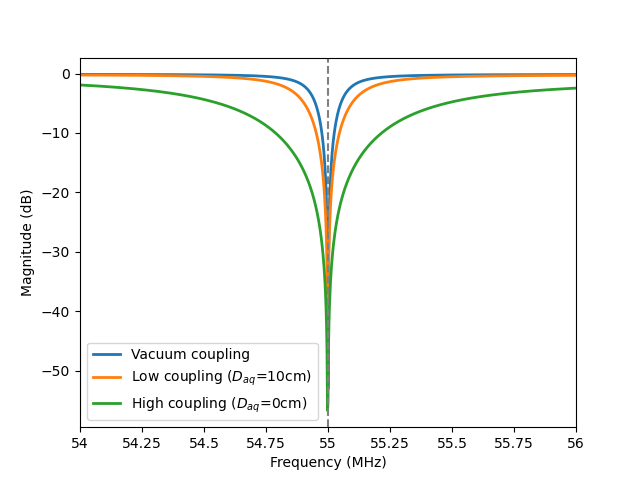

In [9]:
fig, ax = plt.subplots()
ant_vac_coupling.circuit().network.plot_s_db(m=0, n=0, ax=ax, label='Vacuum coupling', lw=2)
ant_low_coupling.circuit().network.plot_s_db(m=0, n=0, ax=ax, label='Low coupling ($D_{aq}$=10cm)', lw=2)
ant_high_coupling.circuit().network.plot_s_db(m=0, n=0, ax=ax, label='High coupling ($D_{aq}$=0cm)', lw=2)
ax.axvline(f_match, color='gray', ls='--')

Now, keep the antenne matched for the vacuum case and let's vary the coupling cases to check the resulting VSWR and coupling resistance Rc

In [10]:
power = [1, 0]
phase = [1, 0]
idx_f_match = np.argmin(np.abs(freq.f - f_match))

VSWR, Rcs = [], []
for s_file in tqdm(s_files):
    _ant = WestIcrhAntenna(frequency=freq, antenna_s4p_file=s_dir+s_file)
    _ant.Cs = C_match_vac
    _VSWR = _ant.vswr_act(power, phase)[idx_f_match]
    _Rcs = _ant.Rc(power, phase)[idx_f_match]   
    VSWR.append(_VSWR)
    Rcs.append(_Rcs)
VSWR_vac = np.array(VSWR)
Rcs_vac = np.array(Rcs)

C:\Users\JH218595\Documents\scikit-rf\skrf\network.py:6069: RuntimeWarning: divide by zero encountered in true_divide
  s_act[fidx] = npy.matmul(s[fidx], a) / a
..\west_ic_antenna\antenna.py:674: RuntimeWarning: invalid value encountered in true_divide
  vswr_right = (1 + np.abs(s_act[:,1]))/(1 - np.abs(s_act[:,1]))
..\west_ic_antenna\antenna.py:804: RuntimeWarning: invalid value encountered in multiply
  return power*np.abs(s_act)**2


proceed the same but with the matching point set for high coupling case:

In [11]:
power = [1, 0]
phase = [1, 0]
idx_f_match = np.argmin(np.abs(freq.f - f_match))

VSWR, Rcs = [], []
for s_file in tqdm(s_files):
    _ant = WestIcrhAntenna(frequency=freq, antenna_s4p_file=s_dir+s_file)
    _ant.Cs = C_match_high
    _VSWR = _ant.vswr_act(power, phase)[idx_f_match]
    _Rcs = _ant.Rc(power, phase)[idx_f_match]   
    VSWR.append(_VSWR)
    Rcs.append(_Rcs)
VSWR_high = np.array(VSWR)
Rcs_high = np.array(Rcs)

<IPython.core.display.Javascript object>


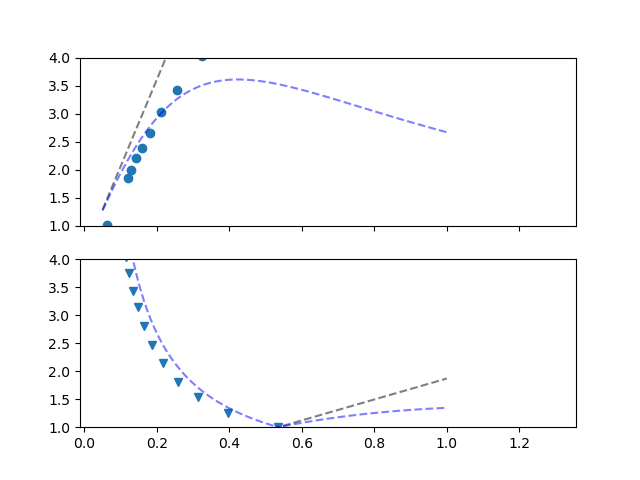

(1.0, 4.0)

In [12]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(Rcs_vac[:,0], VSWR_vac[:,0], 'o', label='vacuum match')
ax[1].plot(Rcs_high[:,0], VSWR_high[:,0], 'v', label='high coupling match')
rcs = np.linspace(0.08, 1, 101)
#ax.plot(rcs, rcs/Rcs[-1,0], '--')
[a.set_ylim(1, 5) for a in ax]

Z_T = _ant.Z_T(power, phase, Cs=C_match_vac)[idx_f_match,0].real
alpha = rcs / Rcs_vac[0,0]
k = Z_T / Rcs_vac[0,0]

rcs = np.linspace(0.05, 1, 101)
ax[0].plot(rcs, alpha, '--', color='gray')
ax[0].plot(rcs, 1/alpha, '--', color='b', alpha=0.5)
ax[0].plot(rcs, (2*k*alpha)/(alpha**2 + 2*k - 1), '--', color='b', alpha=0.5)
ax[0].set_ylim(1, 4)


Z_T = _ant.Z_T(power, phase, Cs=C_match_high)[idx_f_match,0].real
alpha = rcs / Rcs_high[1,0]
k = Z_T / Rcs_high[1,0]

rcs = np.linspace(0.05, 1, 101)
ax[1].plot(rcs, alpha, '--', color='gray')
ax[1].plot(rcs, 1/alpha, '--', color='b', alpha=0.5)
ax[1].plot(rcs, (2*k*alpha)/(alpha**2 + 2*k - 1), '--', color='b', alpha=0.5)
ax[1].set_ylim(1, 4)


In [13]:
power = [1, 0]
phase = [1, 0]
idx_f_match = np.argmin(np.abs(freq.f - f_match))

VSWR, Rcs = [], []
for s_file in tqdm(s_files):
    _ant = WestIcrhAntenna(frequency=freq, antenna_s4p_file=s_dir+s_file)
    _ant.Cs = C_match_med
    _VSWR = _ant.vswr_act(power, phase)[idx_f_match]
    _Rcs = _ant.Rc(power, phase)[idx_f_match]   
    VSWR.append(_VSWR)
    Rcs.append(_Rcs)
VSWR_med = np.array(VSWR)
Rcs_med = np.array(Rcs)

C:\Users\JH218595\Documents\scikit-rf\skrf\network.py:6069: RuntimeWarning: divide by zero encountered in true_divide
  s_act[fidx] = npy.matmul(s[fidx], a) / a
..\west_ic_antenna\antenna.py:674: RuntimeWarning: invalid value encountered in true_divide
  vswr_right = (1 + np.abs(s_act[:,1]))/(1 - np.abs(s_act[:,1]))
..\west_ic_antenna\antenna.py:804: RuntimeWarning: invalid value encountered in multiply
  return power*np.abs(s_act)**2


<IPython.core.display.Javascript object>


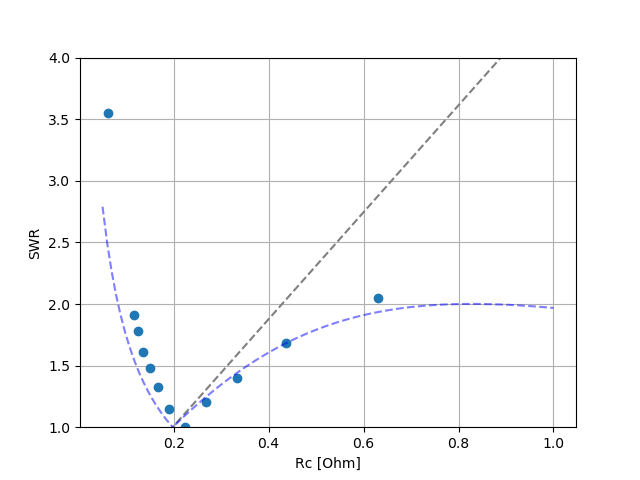

(1.0, 4.0)

In [14]:
fig, ax = plt.subplots()
ax.plot(Rcs_med[:,0], VSWR_med[:,0], 'o', label='intermediate match')
rcs = np.linspace(0.08, 1, 101)

ax.grid(True)
ax.set_xlabel('Rc [Ohm]')
ax.set_ylabel('SWR')

Z_T = _ant.Z_T(power, phase, Cs=C_match_med)[idx_f_match,0].real
alpha = rcs / Rcs_med[5,0]
k = Z_T / Rcs_med[5,0]

rcs = np.linspace(0.05, 1, 101)
ax.plot(rcs, alpha, '--', color='gray')
ax.plot(rcs, 1/alpha, '--', color='b', alpha=0.5)
ax.plot(rcs, (2*k*alpha)/(alpha**2 + 2*k - 1), '--', color='b', alpha=0.5)
ax.set_ylim(1, 4)

In [19]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')